<a href="https://colab.research.google.com/github/dchug2/ATMS597_Project6_GroupA/blob/master/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import xarray as xr
from google.colab import drive
import os
import pandas as pd
import sklearn
%pylab inline
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/Academics/ATMS597_dataanalysis/Project6/ATMS597_Project6_RoRaDi')

Populating the interactive namespace from numpy and matplotlib
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load data
MLE_df = pd.read_pickle('Data/roradi_df_smooth_nino34_mjo.pkl')
MLE_df.index = pd.to_datetime(MLE_df.index)

# add number of days passed, to capture linear trends
MLE_df['annual'] = (MLE_df.index - MLE_df.index[0]).days

# add DOY to capture any annual cycle dependencies
MLE_df['doy'] = MLE_df.index.dayofyear

# pairwise comparison
#column_names2 = ['pre_lag','pre', 'SM_root', 'SM_sfc', 'oni', 'mjo_amp']
#g = sns.pairplot(MLE_df[column_names2])

# Let's focus on the NDJFM season
datemask = ((MLE_df.index.month >= 11) | (MLE_df.index.month <= 3))
MLE_df = MLE_df.loc[datemask]

In [0]:
predictand = 'pre_lag'
#remove_cols = ['mjo_amp', 'nino34', 'SM_sfc']

# split data into training and testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

y = MLE_df[predictand]
X = MLE_df.drop([predictand],axis=1)
#[X.drop([col], axis = 1, inplace = True) for col in remove_cols]
X

,mjo_pc1,mjo_pc2,mjo_amp,mjo_phase,nino34,pre,SM_root,SM_sfc,mjo_amp_smooth,nino34_smooth,annual,doy
2003-01-16,-0.777080,0.788010,1.106710,7.0,0.930344,1.647427,0.026193,0.031361,0.815463,0.866591,0,16
2003-01-17,-0.925970,0.590461,1.098210,8.0,0.887793,1.333300,0.026171,0.030602,0.797835,0.840954,1,17
2003-01-18,-0.846530,0.445489,0.956596,8.0,0.827557,1.135476,0.025972,0.029496,0.792994,0.814361,2,18
2003-01-19,-0.865040,0.492584,0.995454,8.0,0.813253,0.996657,0.025656,0.028262,0.792928,0.786310,3,19
2003-01-20,-0.339460,0.316589,0.464182,8.0,0.806353,0.940552,0.025265,0.027231,0.792772,0.759723,4,20
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,0.211502,1.343076,1.359627,6.0,-0.666866,-0.804285,0.025541,0.022407,1.387604,-0.642420,5549,86
2018-03-28,0.053081,1.496526,1.497467,6.0,-0.693226,-0.861734,0.024753,0.020767,1.411569,-0.624584,5550,87
2018-03-29,-0.283600,1.656813,1.680910,7.0,-0.614441,-0.959726,0.023848,0.019298,1.442175,-0.608155,5551,88
2018-03-30,-0.612975,1.413206,1.540419,7.0,-0.515360,-0.884547,0.022984,0.018526,1.481192,-0.594909,5552,89


In [0]:
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size = 0.1,random_state = 10)

In [0]:
# Import sklear modules that will help with the model fitting
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Setup random forest parameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_precip = RandomForestRegressor()

rf_random_precip = RandomizedSearchCV(estimator = rf_precip, cv=3, param_distributions = random_grid, n_iter = 100, verbose=2, random_state=42, n_jobs = -1)

%timeit rf_random_precip.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 27.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [0]:
rf_random_precip.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Fit the model using best parameters
best_random_precip = rf_random_precip.best_estimator_

# Predict the values
Predict = best_random_precip.predict(X_test)

print('Root Mean Square Error:', round(sqrt(mean_squared_error(y_test, Predict)), 2))

Root Mean Square Error: 0.28


RMSE for training dataset =  2.0336397391063886e-05


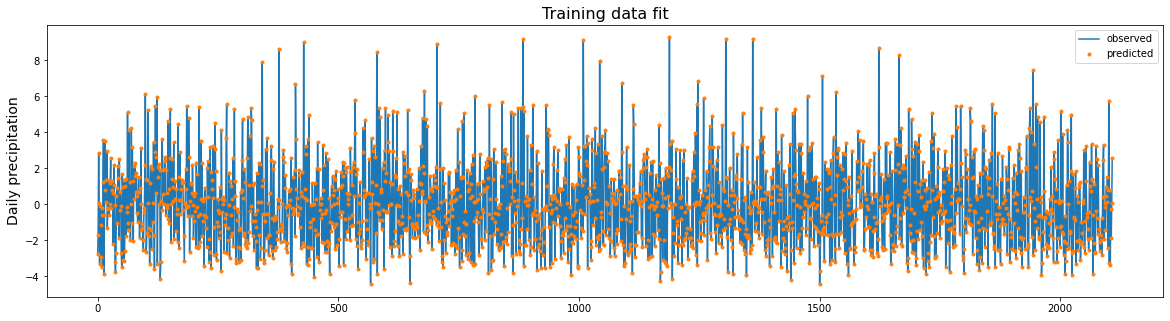

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

RFR = RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
RFR.fit(X_train, y_train)
predicted_train =  RFR.predict(X_train)

# Calculate RMSE on training data
rmse_train = np.sqrt(mean_squared_error(y_train, predicted_train))
print('RMSE for training dataset = ', rmse_train)

# plot the predicted and predictand data
fig, ax = plt.subplots(figsize = (20, 5))
xidx = np.arange(np.size(y_train))
plt.plot(xidx, y_train, label = 'observed')
plt.plot(xidx, predicted_train, '.', label = 'predicted')
plt.title('Training data fit', fontsize = 16)
plt.ylabel('Daily precipitation', fontsize = 14)
plt.legend(loc = 'best')
plt.show()

RMSE for test dataset =  0.3020019205143586


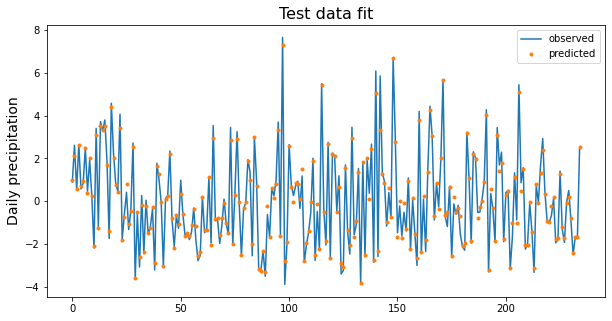

In [0]:
# Evaluate on test data
predicted_test =  RFR.predict(X_test)
# Calculate RMSE on test data
rmse_test = np.sqrt(mean_squared_error(y_test, predicted_test))
print('RMSE for test dataset = ', rmse_test)

# plot the predicted and predictand data
fig, ax = plt.subplots(figsize = (10, 5))
xidx = np.arange(np.size(y_test))
plt.plot(xidx, y_test, label = 'observed')
plt.plot(xidx, predicted_test, '.', label = 'predicted')
plt.title('Test data fit', fontsize = 16)
plt.ylabel('Daily precipitation', fontsize = 14)
plt.legend(loc = 'best')
plt.show()

In [0]:
y_test_binary = np.sign(y_test)
predicted_test_binary = np.sign(predicted_test)
compare = np.equal(y_test_binary, predicted_test_binary)*1

# plot the predicted and predictand data
print('Percentage of total predicted values with correct sign =', np.sum(compare)/np.size(compare)*100, '%')

Percentage of total predicted values with correct sign = 97.44680851063829 %


[Text(0, 0, 'mjo_pc1'),
 Text(0, 0, 'mjo_pc2'),
 Text(0, 0, 'mjo_amp'),
 Text(0, 0, 'mjo_phase'),
 Text(0, 0, 'nino34'),
 Text(0, 0, 'pre'),
 Text(0, 0, 'SM_root'),
 Text(0, 0, 'SM_sfc'),
 Text(0, 0, 'mjo_amp_smooth'),
 Text(0, 0, 'nino34_smooth'),
 Text(0, 0, 'annual'),
 Text(0, 0, 'doy')]

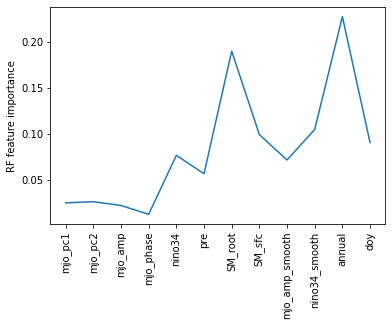

In [0]:
features = X_train.columns
importance = RFR.feature_importances_
plt.plot(importance)
plt.ylabel('RF feature importance')
dummylist = plt.gca().get_xticklabels()
plt.gca().set_xticks(np.arange(len(features)))
plt.gca().set_xticklabels(features,rotation=90)